# Image Reduction

In the Astropy I tutorial, we looked at an image of Messier 3. We hope you found it pretty, but when it comes to getting science out of it, pretty is not enough. For most astronomical sources, the only means of getting information about them is electromagnetic waves, popularly known as light. Hence, it becomes necessary to have precise measurement of light coming from our source of interest. This measurement is known as [photometry](https://en.wikipedia.org/wiki/Photometry_(astronomy)) and is pivotal for getting meaningful results out of data.

However, a raw CCD image is far from fit to be used for science. Let us see why.

(Note: Several aspects of this tutorial have been adapted from the tutorial on [Image Reduction Module](http://growth.caltech.edu/growth-astro-school-2018-resources.html) from the [GROWTH Winter School 2018](http://growth.caltech.edu/growth-winter-school-2018.html), which was held in IIT Bombay in December 2018)

## CCD Cameras in Astronomy

[CCD cameras](https://en.wikipedia.org/wiki/Charge-coupled_device#Use_in_astronomy) have been a huge upgrade over the traditional use of [photographic plates](https://en.wikipedia.org/wiki/Photographic_plate#Astronomy) for astronomical imaging. This is primarily due to their high quantum efficiency (an efficiency of 100% implies one count for each incident photon) and linearity in output. In other words, if the quantum efficiency is 80% and 100 photons are incident on a CCD pixel, the output will show around 80 counts. Linearity implies that the same pixel will show close to 160 counts if 200 photons were incident. These two properties combined with a bunch of other convenient properties have established CCD cameras as the primary detectors for telescopes.

### So how do they work?

(CCDs by themselves can be a standalone topic to study. However, we shall look at them from a simplistic point of view in this tutorial.)

A CCD camera chip is basically a grid of pixels (4108x4096 in our case), each pixel being a tiny capacitor. The camera shutter is initially closed and these capacitors are maintained at a certain voltage, known as the **Bias Voltage**. As soon as we open the shutter, photons are incident on the surface of our camera. Each pixel acts as a "photon bucket" and counts the number of incident photons in the form of electrons (thanks to the [Photoelectric effect](https://en.wikipedia.org/wiki/Photoelectric_effect)). Once our exposure is finished, the shutter is closed and the charge stored in the form of electrons in each pixel is "read out". This is how we get our image in the form of a FITS file, which we explored a bit in the Astropy tutorial.

However, since a CCD is an electronic device, it is impossible to escape noise and errors. Consequently, it becomes important to get rid of as many errors as possible before declaring the image fit to be used for science. 

This process of converting a raw image into a "useful" image is known as **Image Reduction**.

Before starting this tutorial, **you are encouraged** to go through [this](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=2&ved=2ahUKEwif1qPA3oPpAhWn7nMBHfRBDhMQFjABegQIDBAD&url=https%3A%2F%2Fwww.aavso.org%2Ffiles%2Fimage_calibration-v1.pdf&usg=AOvVaw38WCFirYcCzT9rcH-udbiQ) document that will introduce you to Bias, Flat and Dark frames, and why each of them is crucial to Image Reduction.

The images we're using were taken using the [GROWTH-India Telescope](https://sites.google.com/view/growthindia/) for which the CCD ambient temperature is -60<sup>o</sup>C. The dark current at such low temperatures is negligible, and hence only the Flat and Bias frames are used.

Download the data for this tutorial from [here](https://drive.google.com/open?id=1NAvPOt4jQU-oQq4s0fD6JqqiBfwxex59) and extract the contents at the location of this notebook. The contents of the zip file include 2 FITS files and a folder. Move them **as they are** to the folder which contains this notebook. 

In [1]:
# %matplotlib notebook

import numpy as np
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
import matplotlib.pyplot as plt
import glob
import os

Here we import all the necessary things. 

You can see two new imports, `glob` and `os`. We shall be using these to look at a new way to access data files in our directory

## The Raw image

The image of Messier 3 that we used in a previous tutorial shall be our raw image here. In other words, it is absolutely untouched after being read out from the CCD, and needs to be processed before calling it science-worthy. As we saw earlier, this FITS has data in the form of a 4096 x 4108 array of photon counts. We will call this image distribution $I(x,y)$ as a function of x, y coordinates.


## Creating a Master Bias frame
The bias, if you recall from the reading earlier, is an offset due to the voltage applied on the CCD. This varies from pixel to pixel, since the bias is applied only to one side (or a few sides, for a large CCD). So we must subtract this offset before we can proceed further. This is not a time dependent phenomena, and in practice it is taken with a very small exposure. 

We shall first create a master bias $B(x,y)$ to be subtracted from each of the flat images and the raw image. The idea is to use a median combination of multiple bias frames to get rid of transient features like cosmic rays in each of the individual bias frames, and create a 'Master bias' frame.

In [2]:
# This returns the current path of the folder we are in
curpath = os.path.abspath('.')                  
# If you have extracted correctly, there should be a sub-folder named Bias, and you should get 3 files in the next cell
biasFolder = os.path.join(curpath, 'bias')   

This is a new way to access files from our directory. It will save us the effort of loading each Bias frame from the `bias` folder individually.

In [3]:
biasList = glob.glob(os.path.join(biasFolder,'*fits'))

numBiasFiles = len(biasList)
print('Found %d bias files' %numBiasFiles)

Found 3 bias files


Let us now load all the Bias images into a numpy 3D array, with each element being a 4096 x 4108 pixel array corresponding to each Bias image.

In [4]:
biasImages = np.zeros((4108, 4096, numBiasFiles))

for i in range(numBiasFiles):
        biasImages[:,:,i] = fits.open(biasList[i])[0].data

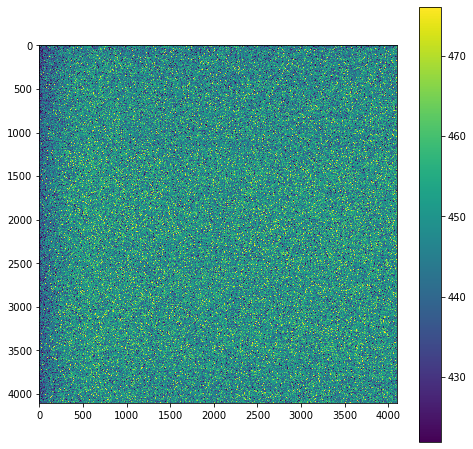

In [11]:
# This is to get a good scale on the plot, nothing more
mean, median, std = sigma_clipped_stats(biasImages[:,:,1])

plt.figure(figsize=(8,8))
plt.imshow(biasImages[:,:,1], vmin = median - 3*std, vmax = median + 3*std)
plt.colorbar()

Not so interesting, is it? Don't be surprised, it is essentially a zero second exposure with the shutter closed. Nevertheless, it is very crucial for Image Reduction of CCD images. Let us now make the Master Bias frame and plot it.

[[445. 431. 429. ... 448. 449. 454.]
 [426. 436. 433. ... 443. 438. 436.]
 [437. 434. 429. ... 445. 437. 458.]
 ...
 [446. 429. 436. ... 443. 443. 451.]
 [428. 437. 431. ... 452. 435. 449.]
 [436. 434. 427. ... 448. 452. 435.]]


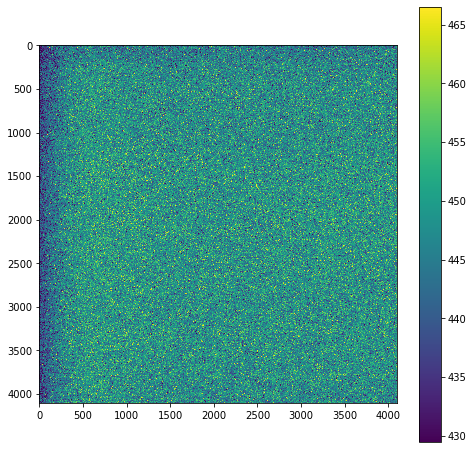

In [12]:
masterBias = np.median(biasImages, axis=2)
print(masterBias)

mean, median, std = sigma_clipped_stats(masterBias)

plt.figure(figsize=(8,8))
plt.imshow(masterBias, vmin = median - 3*std, vmax = median + 3*std)
plt.colorbar()

So we finally have our Master Bias. Looks pretty much the same. But you can see that the random pixel flare-ups from individual bias frames have been eliminated using the median. The next step is to make the Master Flat.

## Creating a Master Flat frame
Flats are essentially the response of the CCD to uniform light. This is due to a variety of reasons including telescope optics, slight differences in the sizes of the pixels in the CCD, and possibly even dust.

The same procedure needs to be followed for Flats. So to make your job easy, we have already median-combined a few Flat frames (these were taken during the evening twilight at Hanle). All that needs to be done now is the subtraction of Master Bias from this file to get a Master Flat frame. We shall denote it by $F(x,y)$.


In [13]:
Flat = fits.open('Flat.fits')[1].data

masterFlat = Flat - masterBias

# This re-scaling is so that we get a reasonable range in the final processed image. 
masterFlat = masterFlat/np.median(masterFlat)

Let's look at a plot of our Master Flat frame. Again, don't expect it to look good, it's just a Flat frame!

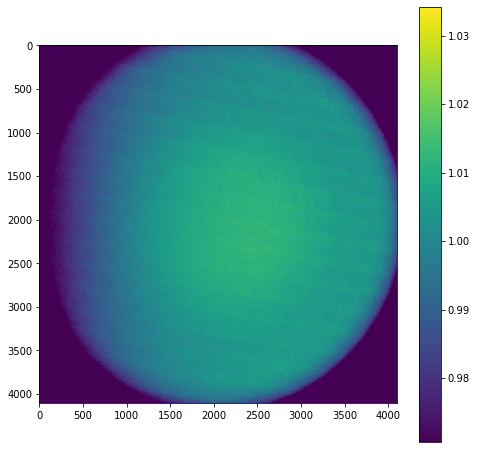

In [14]:
mean, median, std = sigma_clipped_stats(masterFlat)
plt.figure(figsize=(8,8))
plt.imshow(masterFlat, vmin = median - 3*std, vmax = median + 3*std)
plt.colorbar()

At this point, we have the necessary calibration images to reduce our raw image and visualize the true brightness distribution on the sky. Let the true brightness distribution on the sky be $S(x,y)$, then the image $I(x,y)$ can be expressed as:

## \begin{equation}
I(x,y) = F(x,y) \,  S(x,y) + B(x,y)
\end{equation}

So, the sole task that remains is to retrieve $S(x,y)$ from $I(x,y)$.

## Almost there...

We now possess everything required to carry out our final step of Image Reduction. Let us create the processed or "science" image.

But first, let's plot the raw image and see again what it looks like.

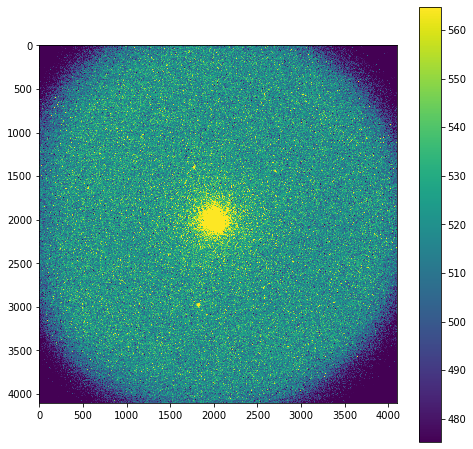

In [15]:
rawHDU = fits.open('Messier3_raw.fits')[0]
rawData = rawHDU.data

# Let us have a look at the image:
plt.figure(figsize = (8,8))
mean, median, std = sigma_clipped_stats(rawData)
plt.imshow(rawData, vmin = median - 3*std, vmax = median + 3*std)
plt.colorbar()

To get the final output in the form of a FITS file, we need to write the processed data onto a FITS HDU, which we shall further write onto a new FITS file. Note that we need to copy the same Header as the raw image onto the processed image so that the essential information is intact and carried forward. 

In [16]:
rawHeader = rawHDU.header

procData = (rawData - masterBias) / masterFlat

procHDU = fits.PrimaryHDU(procData)
procHDU.header = rawHeader

procHDU.writeto('Messier3.proc.fits', overwrite=True)

We have written the processed data onto a new file "Messier3.proc.fits". Let us plot this new image to check whether it was written successfully.

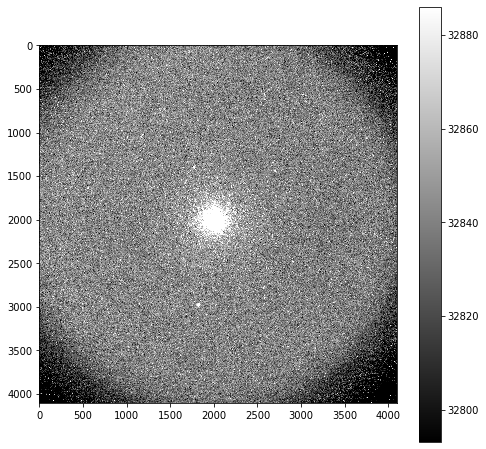

In [18]:
M3_HDU = fits.open('Messier3.proc.fits')[0]
M3_data = M3_HDU.data

plt.figure(figsize = (8,8))
mean, median, std = sigma_clipped_stats(M3_data)
plt.imshow(M3_data, vmin = median - 3*std, vmax = median + 3*std,cmap='gray')
plt.colorbar()

## Your Assignment ...

...should you choose to accept it will be the following:


1. Plot the histogram of the background (as you did in the Astropy1 tutorial). Do you see any changes? Can you track down in which step the change came about?
2. There are a lot more aspects to image reduction than the steps here. Read up about these steps (which include cosmic ray removal, astrometry and possibly stacking) in the resources given below. 
3. The main purpose of the GROWTH-India Telescope is to find transients. These can be anything from Supernova (and other magnitudes of Novae) to afterglows of Gamma Ray Bursts, to Electromagnetic Counterparts of Gravitational Wave Sources. To keep in line with this, let us try to use a technique known as Image Subtraction, albeit with some simplifications (OK, that was a lie. Lots of simplification). Read more below

In [19]:
def get_background_histogram(array, min_count, max_count):
    """
        array is the numpy array that contains the counts for each pixel
        the bins for the histogram will be np.arange(min_count, max_count, 1)
    """
    flattened_array = array.flatten()
    num_pixels, bin_edges = np.histogram(flattened_array, bins=np.arange(min_count, max_count, 1))
    bins = 0.5*(bin_edges[1:] + bin_edges[:-1])
    return bins, num_pixels

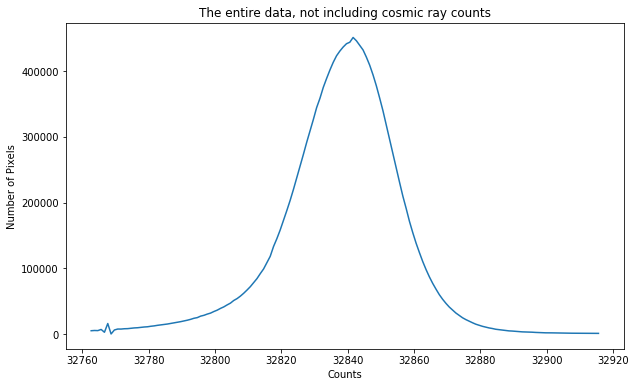

In [21]:
mean, median, std = sigma_clipped_stats(M3_data)

vmin = median - 5*std
vmax = median + 5*std
bins, num_pixels = get_background_histogram(M3_data,vmin,vmax) #entire data, not including cosmic ray counts

plt.figure(figsize = (10,6))
plt.title("The entire data, not including cosmic ray counts")
plt.xlabel('Counts')
plt.ylabel('Number of Pixels')
plt.plot(bins, num_pixels)

## Image Subtraction
Often in crowded fields (like the one we have now), or for transients from close to the centers of other galaxies, it becomes difficult to pin-point a new source by eye, or by blinking two images. So, we turn to other techniques, one of which is Image Subtraction. In this, we take a reference frame of the same field of view, and subtract it from the image in which we suspect there is a transient. Then any new source should, in theory, be very visible. 

There is a processed file (`M3_transient.proc.fits`) which has a nova in it somewhere (Before you read the Header for the observation time and get excited, this is an artificial injection). Try to subtract the image (this is the easy part) assuming no rotation of the field of view, or differences in exposure time (which you'll have had to correct for) or differences in the Point Spread Functions of the telescope (which you would also have had to correct for). In practice, these steps must be taken, and image subtraction is a lot more complicated than it would seem from this example. 

When you get the subtracted image, try to find all 5$\sigma$ sources (in the artificial injection, there will only be one). This means, you have to find all pixels, which have counts more than the mean (or median) plus 5 times the standard deviation of the background. Remember to use `sigma_clipped_stats` so that any potential sources don't contribute to your background estimations!!

Can you make a function that takes in a reference image and a science image and returns the pixels which have counts more than the median+5$\cdot$sigma?

## More on Image reduction
What we have covered here is a very small part of image reduction. As mentioned before, this tutorial is based off of the [Image Reduction Module](http://growth.caltech.edu/growth-astro-school-2018-resources.html) of the [GROWTH Winter School 2018](http://growth.caltech.edu/growth-winter-school-2018.html), which is a more complete version, and also contains steps to further process the images. Note that some softwares and packages are supported only on Linux systems.

There is also a module on Image Subtraction, which you can see for more details.

# Big Surprise
As you have seen, we can get pictures that are quite pretty (after of course, some processing). Here is an opportunity for you to do some observing from the GROWTH-India Telescope. You can submit any target, along with a short write-up on why you want to observe the target (make sure it is visible from Hanle, Ladakh at this time of the year at night!). The best target(s) (with good write-ups) will be observed using the telescope, and the processed images shall be provided to you for post-processing (of course, we will help as much as you want in this as well). If you get great looking images, they might even be featured on the GROWTH-India official website. 

So head on over to https://forms.gle/uxefymhK7ZPNjHeZ7 to submit your proposals. But do keep in mind that the sensitivity of the telescope and the detector makes it difficult to observe very bright sources, which get saturated very fast. 

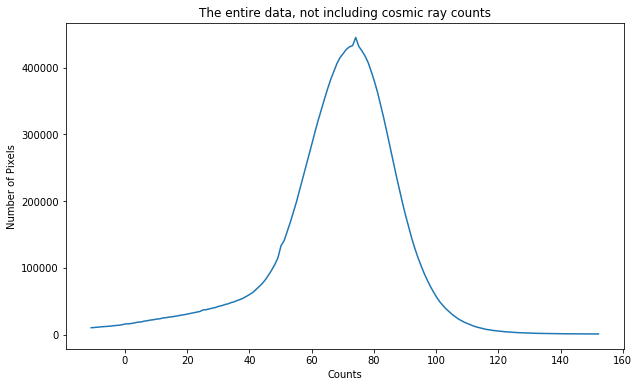

In [23]:
testdata = (rawData - masterBias)

mean, median, std = sigma_clipped_stats(testdata)

vmin = median - 5*std
vmax = median + 5*std
bins, num_pixels = get_background_histogram(testdata,vmin,vmax) #entire data, not including cosmic ray counts

plt.figure(figsize = (10,6))
plt.title("The entire data, not including cosmic ray counts")
plt.xlabel('Counts')
plt.ylabel('Number of Pixels')
plt.plot(bins, num_pixels)